# Finding the right capcha with Keras

In [3]:
import os
import numpy as np
import tools as im
from matplotlib import pyplot as plt
from skimage.transform import resize
%matplotlib inline

In [4]:
path=os.getcwd()+'/' # finds the path of the folder in which the notebook is
path_train=path+'images/train/'
path_test=path+'images/test/'
path_real=path+'images/real_world/'

We first define a function to prepare the datas in the format of keras (theano). The function also reduces the size of the imagesfrom 100X100 to 32X32.

In [5]:
def prep_datas(xset,xlabels):
    X=list(xset)
    for i in range(len(X)):
        X[i]=resize(X[i],(32,32,1)) #reduce the size of the image from 100X100 to 32X32. Also flattens the color levels
        
    X=np.reshape(X,(len(X),1,32,32)) # reshape the liste to have the form required by keras (theano), ie (1,32,32)
    X=np.array(X) #transforms it into an array
    Y = np.eye(2, dtype='uint8')[xlabels] # generates vectors, here of two elements as required by keras (number of classes) 
    return X,Y

We then load the training set and the test set and prepare them with the function prep_datas.

In [6]:
training_set, training_labels = im.load_images(path_train)
test_set, test_labels = im.load_images(path_test)
X_train,Y_train=prep_datas(training_set,training_labels)
X_test,Y_test=prep_datas(test_set,test_labels)

Image before/after compression

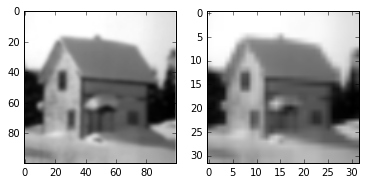

In [15]:
i=11
plt.subplot(1,2,1)
plt.imshow(training_set[i],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(X_train[i][0],cmap='gray')

Lenet neural network 

In [18]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.optimizers import SGD

# this code comes from http://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/

class LeNet:
	@staticmethod
	def build(width, height, depth, classes, weightsPath=None):
		# initialize the model
		model = Sequential()

		# first set of CONV => RELU => POOL
		model.add(Convolution2D(20, 5, 5, border_mode="same",input_shape=(depth, height, width)))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

		# second set of CONV => RELU => POOL
		model.add(Convolution2D(50, 5, 5, border_mode="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

		# set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(500))
		model.add(Activation("relu"))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

Using Theano backend.


We build the neural network and fit it on the training set

In [19]:
model = LeNet.build(width=32, height=32, depth=1, classes=2)
opt = SGD(lr=0.01)#Sochastic gradient descent with learning rate 0.01
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
model.fit(X_train, Y_train, batch_size=10, nb_epoch=300,verbose=1)

Epoch 1/300
25/25 [==============================] - 0s - loss: 0.6774 - acc: 0.6400     
Epoch 2/300
25/25 [==============================] - 0s - loss: 0.5405 - acc: 0.9200     
Epoch 3/300
25/25 [==============================] - 0s - loss: 0.4367 - acc: 0.9200     
Epoch 4/300
25/25 [==============================] - 0s - loss: 0.3663 - acc: 0.9200     
Epoch 5/300
25/25 [==============================] - 0s - loss: 0.3214 - acc: 0.9200     
Epoch 6/300
25/25 [==============================] - 0s - loss: 0.3057 - acc: 0.9200     

In [21]:
y_pred = model.predict_classes(X_test)
print(y_pred)
print(test_labels)

2/2 [==============================] - 0s
[1 0]
[1, 0, 0, 0, 0, 0]


We now compare with the real world images (with the deshear method)

In [74]:
real_world_set=[]
for i in np.arange(1,73):
    filename=path+'images/real_world/'+str(i)+'.png'
    real_world_set.append(im.deshear(filename))
fake_label=np.ones(len(real_world_set),dtype='int32')
X_real,Y_real=prep_datas(real_world_set,fake_label)
y_pred = model.predict_classes(X_real)

32/72 [============>.................] - ETA: 0s

with the labels of Peter

In [75]:
f=open(path+'images/real_world/labels.txt',"r")
lines=f.readlines()
result=[]
for x in lines:
    result.append((x.split('	')[1]).replace('\n',''))
f.close()

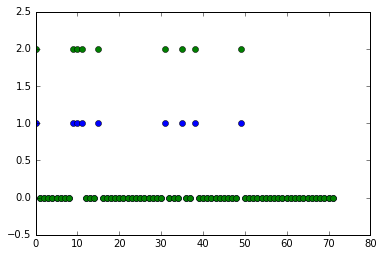

In [84]:
result=np.array([int(x) for x in result])
result[result>1]=1
plt.plot(y_pred,'o')
plt.plot(2*result,'o')
plt.ylim(-0.5,2.5);